In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime



from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, plot_precision_recall_curve, precision_recall_curve, precision_score, recall_score

from sklearn.model_selection import RandomizedSearchCV, train_test_split
import shap
import lightgbm as lgb 

pd.set_option('max_colwidth', 80)

In [2]:
df = pd.read_csv('final_data.csv') 
df.head()

,TARGET_FID,Length,Install_year,Arterial_class,Surface_width,Speed_limit,Slope,Width,Break_Yr,Target,...,Surface_type_,Surface_type_AC,Surface_type_AC/AC,Surface_type_AC/PCC,Surface_type_GRAVEL,Surface_type_PCC,Surface_type_ST,AGE,Nearby_breaks_1yr,Process_year
0,1,314.79,1972,2.0,40.0,25.0,0.0,8.0,NaN,0,...,0,0,0,0,0,1,0,38,0,2010
1,2,363.39,1972,0.0,46.0,20.0,4.0,8.0,NaN,0,...,0,1,0,0,0,0,0,38,0,2010
2,3,323.51,1972,0.0,46.0,20.0,4.0,8.0,NaN,0,...,0,1,0,0,0,0,0,38,0,2010
3,4,329.13,1928,0.0,0.0,20.0,6.0,12.0,NaN,0,...,0,0,0,0,0,0,1,82,0,2010
4,5,273.64,1928,2.0,42.0,25.0,4.0,18.0,NaN,0,...,0,0,0,1,0,0,0,82,0,2010


In [3]:
df['Target'].unique()

array([0, 1])

In [4]:
df_2014 = df[df['Process_year'] == 2014]
df_2014.shape

(68274, 56)

In [5]:
df_2014['Break_Yr'].unique()

array([  nan, 2014.])

In [6]:
columns = df_2014.columns.drop(['TARGET_FID', 'Process_year', 'Break_Yr'])
df_2014_cols = df_2014[columns]
print(df_2014_cols.shape)
#df_2014_cols_cleaned = df_2014_cols[~df_2014_cols.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float32) # removes rows with nan or inf points
df_2014_cols_cleaned = df_2014_cols.dropna(axis=0).astype(np.float32) # removes rows with nan or inf points
print(df_2014_cols_cleaned.shape)


(68274, 53)
(58917, 53)


In [7]:
features_df = df_2014_cols_cleaned.drop('Target', axis=1)
target_df = df_2014_cols_cleaned[['Target']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2)

In [17]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)


ExtraTreesClassifier()

In [21]:
preds = etc.predict(X_test)
probs = etc.predict_proba(X_test)
bal_acc = balanced_accuracy_score(y_pred=preds, y_true=y_test)
recall = recall_score(y_true=y_test, y_pred=preds)
precision = precision_score(y_true=y_test, y_pred=preds)
print(bal_acc)
print(recall)
print(precision)

0.6632526992148443
0.32727272727272727
0.6666666666666666


In [19]:
confusion_matrix(y_test, preds)

array([[11720,     9],
       [   37,    18]])

array([ 6,  0,  1, 50,  5,  3, 51,  2,  4, 21, 28, 48, 29, 44, 30, 40, 12,
       46, 49, 24, 32, 33, 41, 45, 23, 15, 16, 43, 11,  9, 10, 19, 17, 47,
       39, 35, 31, 34, 13, 37,  7, 26, 22, 36, 14, 25, 20, 18, 38,  8, 42,
       27])

Feature ranking:
Width
1. feature 6 (0.411271)

Length
2. feature 0 (0.160369)

Install_year
3. feature 1 (0.078946)

AGE
4. feature 50 (0.077950)

Slope
5. feature 5 (0.075343)

Surface_width
6. feature 3 (0.071799)

Nearby_breaks_1yr
7. feature 51 (0.023488)

Arterial_class
8. feature 2 (0.016406)

Speed_limit
9. feature 4 (0.013105)

Material_Reinforced Concrete Pipe
10. feature 21 (0.008348)

Soil_type_3055
11. feature 28 (0.006514)

Surface_type_PCC
12. feature 48 (0.006512)

Soil_type_3056
13. feature 29 (0.006304)

Surface_type_AC
14. feature 44 (0.005689)

Soil_type_3057
15. feature 30 (0.005463)

Soil_type_988
16. feature 40 (0.005283)

Material_Concrete
17. feature 12 (0.005222)

Surface_type_AC/PCC
18. feature 46 (0.005209)

Surface_type_ST
19. feature 49 (0.004173)

Material_Vitrified Clay
20. feature 24 (0.002783)

Soil_type_3059
21. feature 32 (0.002245)

Soil_type_3060
22. feature 33 (0.002007)

Soil_type_989
23. feature 41 (0.001247)

Surface_type_AC/AC
24. feature 45 (

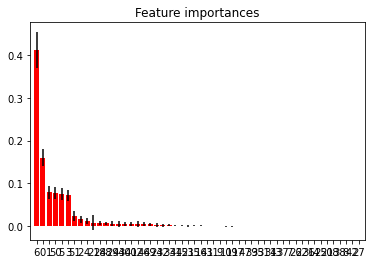

In [46]:
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    feature_name = features[indices[f]]
    print(feature_name)
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print()

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()